## Setup

In [1]:
import pandas as pd
import numpy as np
import pickle
import xgboost as xgb
import matplotlib.pyplot as plt

## Load in Saved XGBoost Model & Data

In [2]:
# Load in trained model
bst = pickle.load(open("../3. ML/bst.pickle.dat", "rb"))

In [3]:
df = pd.read_csv('../data/formatted_mens.csv',header=0,parse_dates=["Date"])
df.dropna(inplace=True)

categorical_cols = ['Tournament', 'Court', 'Surface', 'Round', 'A', 'B']
df = pd.get_dummies(df,columns=categorical_cols,drop_first=True)

In [4]:
df[['Date','y']+bst.feature_names].sort_values(by='Date',inplace=True) #Match model feature labels

## Check we have no missing or extra features
print([c for c in df.columns if c not in bst.feature_names]) # Should be date & y
print([c for c in bst.feature_names if c not in df.columns]) # Should be empty

['Date', 'y']
[]


In [5]:
split_time = pd.to_datetime('2018-01-01') # SAME SPLIT FROM ML EXPLORING
df = df.loc[df['Date']>=split_time]

## Make Predictions

In [6]:
d = xgb.DMatrix(df.drop(columns=['Date','y']), label=df['y'])
df['prediction'] = bst.predict(d)

In [7]:
df['betting_direction'] = (df['prediction'] > 0.5).astype('uint8')
df['correct'] = df['betting_direction'] == df['y']
df

,Date,A_rank,B_rank,APts,BPts,A_Max,B_Max,A_Avg,B_Avg,A_hist_form,...,B_Zhang Ze,B_Zhang Ze.,B_Zhang Zh.,B_Ziadi M.,B_Zopp J.,B_Zverev A.,B_Zverev M.,prediction,betting_direction,correct
44664,2018-01-01,47.0,52.0,1010.0,909.0,1.75,2.35,1.67,2.17,0.50,...,0,0,0,0,0,0,0,0.493191,0,False
44665,2018-01-01,76.0,79.0,670.0,662.0,2.52,1.65,2.37,1.58,0.50,...,0,0,0,0,0,0,0,0.393546,0,False
44666,2018-01-01,218.0,33.0,235.0,1302.0,3.00,1.57,2.73,1.44,0.50,...,0,0,0,0,0,0,1,0.403896,0,True
44667,2018-01-01,66.0,120.0,768.0,498.0,2.38,1.75,2.20,1.66,0.50,...,0,0,0,0,0,0,0,0.416970,0,False
44668,2018-01-01,54.0,94.0,890.0,593.0,2.00,2.02,1.89,1.89,0.50,...,0,0,0,0,0,0,0,0.508752,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50582,2020-11-20,7.0,1.0,5525.0,11830.0,3.92,1.35,3.52,1.31,0.40,...,0,0,0,0,0,0,0,0.247224,0,True
50583,2020-11-20,9.0,4.0,3455.0,6970.0,4.00,1.40,3.60,1.29,0.00,...,0,0,0,0,0,0,0,0.196349,0,True
50584,2020-11-21,3.0,1.0,9125.0,11830.0,2.70,1.66,2.47,1.56,0.30,...,0,0,0,0,0,0,0,0.384299,0,False
50585,2020-11-21,4.0,2.0,6970.0,9850.0,1.95,2.20,1.80,2.04,0.00,...,0,0,0,0,0,0,0,0.569718,1,True


In [8]:
predictions_df = df.loc[:,['prediction','correct']]
df['correct'].mean()

0.6769672407970281

Text(0, 0.5, 'Accuracy')

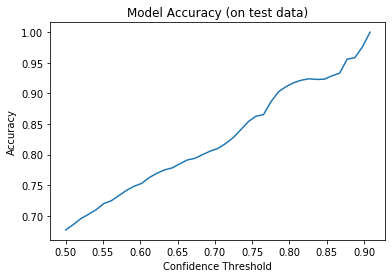

In [9]:
confident_accuracies = []
for p_threshold in np.linspace(0.5,1):
    accuracy = predictions_df[(predictions_df.prediction>p_threshold) | (predictions_df.prediction<1-p_threshold)]['correct'].mean()
    confident_accuracies.append(accuracy)

plt.plot(np.linspace(0.5,1),confident_accuracies)
plt.title('Model Accuracy (on test data)')
plt.xlabel('Confidence Threshold')
plt.ylabel('Accuracy')

In [10]:
use_best_odds = True

if use_best_odds:
    df[['A_odds','B_odds']] = df[['A_Max','B_Max']]
else:
    df[['A_odds','B_odds']] = df[['A_Avg','B_Avg']]

## Hedging Strategy

Given a prediction which we have p confidence in, how much should we hedge? Well betting $\frac{\alpha}{\alpha+\beta}$ will give $\mathbb{E}\left[returns\right]=0$ and var(returns)=0. So we should hedge $h \in [0,\frac{\alpha}{\alpha+\beta}]$

Text(0, 0.5, 'h')

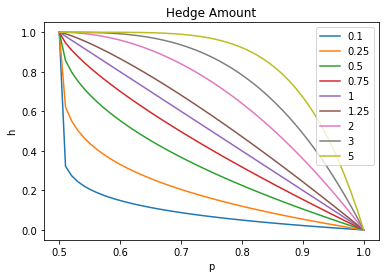

In [11]:
for h_coeff in [0.1,0.25,0.5,0.75,1,1.25,2,3,5]:
    x = np.linspace(0.5,1)
    y = 1-(2*x-1)**h_coeff
    plt.plot(x,y,label=h_coeff)
plt.legend()
plt.title("Hedge Amount")
plt.xlabel('p')
plt.ylabel('h')

Tweaking the 'hedge_coefficient' allows us to select a nice hedging profile, as in the picture above

In [12]:
hedge_coefficient = 1
def hedge_curve(p):
    return (1-(2*p-1)**hedge_coefficient)

In [13]:
min_hedge_amount = 0.25
max_hedge_amount = 0.9
def hedge_amount(alpha,beta,p):
    if p < 0.5:
        return hedge_amount(beta,alpha,1-p) # betting other way
    else:
        largest_sensible_hedge_amount = min((2/(1+beta)),(alpha-1)/(alpha+1)) # Most we can hedge to still be profitable & not rather bet other way
        return np.clip(largest_sensible_hedge_amount * hedge_curve(p),min_hedge_amount,max_hedge_amount)
    
hedge_amount_vectorized = np.vectorize(hedge_amount)

Text(0.5, 1.0, 'Hedge Proportion')

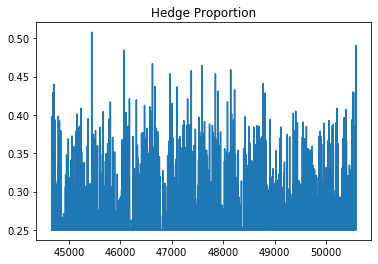

In [14]:
df['h'] = hedge_amount_vectorized(df['A_odds'],df['B_odds'],df['prediction'])

plt.plot(df['h'])
plt.title("Hedge Proportion")

## Calculating Returns and Other Stats

For each bet we make we allocate a unit on the bet+hedge.

In [15]:
def actual_return_or_loss(alpha,beta,p,h):
    if p<0.5:
        return actual_return_or_loss(beta,alpha,1-p,h)
    else:
        return alpha*(1-h)-h , beta*h-(1-h)

actual_return_or_loss_vectorised = np.vectorize(actual_return_or_loss)

In [16]:
df['return_if_we_win_hedged'],df['return_if_we_lose_hedged'] = actual_return_or_loss_vectorised(df['A_odds'],df['B_odds'],df['prediction'],df['h'])
df['return'] = np.where(df['correct'],df['return_if_we_win_hedged'],df['return_if_we_lose_hedged'])

In [17]:
p = np.where(df['prediction']>0.5,df['prediction'],1-df['prediction'])
df['E'] = df['return_if_we_win_hedged']*p + df['return_if_we_lose_hedged']*(1-p)
df['var'] = (df['return_if_we_win_hedged']**2)*p + (df['return_if_we_lose_hedged']**2)*(1-p) - df['E']**2

## Deciding When To Bet

In [83]:
def should_we_bet(alpha,beta,p):
    if p < 0.5:
        return 1-1/beta < p
    else:
        return 1/alpha < p
    
should_we_bet_vectorised = np.vectorize(should_we_bet)

In [84]:
p = np.where(df['prediction']>0.5,df['prediction'],1-df['prediction'])
df['make_bet'] = should_we_bet_vectorised(df['A_odds'],df['B_odds'],df['prediction']) & (1<df['return_if_we_win_hedged'])

In [85]:
left = (np.minimum(1/df['A_odds'],1-1/df['B_odds']) > df['prediction'])
right = (np.maximum(1/df['A_odds'],1-1/df['B_odds']) < df['prediction'])
inside = ~left & ~right

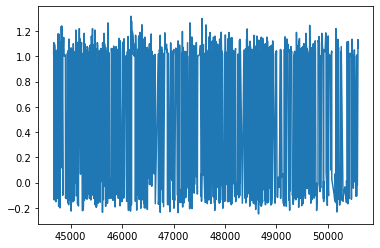

In [86]:
df[right & df['make_bet'] & (df['return_if_we_win_hedged']>1)]['return'].plot()

In [87]:
def squish_range(left,mid,right):
    if right == left: return np.nan
    return 2*mid/(right-left)-1

squish_range=np.vectorize(squish_range)

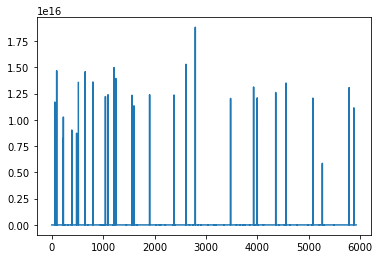

In [88]:
pred_spread = squish_range(np.minimum(1/df['A_odds'],1-1/df['B_odds']),df['prediction'],np.maximum(1/df['A_odds'],1-1/df['B_odds']))
plt.plot(pred_spread)

## Backtesting The Model

In [89]:
bets_df = pd.DataFrame(data=[],columns = ['date','n_bets_made','n_bets_won','return'])
bets_df = bets_df.set_index('date')

In [93]:
for date,b_df in df.groupby('Date'):
    bets_to_make = b_df.loc[b_df['make_bet'],:]
    if bets_to_make.shape[0] < 1:
        continue
    else:
        n_bets_to_make = bets_to_make.shape[0]
        n_bets_won = bets_to_make['correct'].sum()

        weights = np.log(1+bets_to_make['E'])
        weights = weights/weights.sum()
        weighted_returns = weights * bets_to_make['return']

        bets_df.loc[date,:] = [n_bets_to_make,n_bets_won,100*(weighted_returns.sum()-1)]

In [94]:
total_bets_made = bets_df['n_bets_made'].sum()
total_bets_won = bets_df['n_bets_won'].sum()

print("We won ",round(100*total_bets_won/total_bets_made),"% of ",total_bets_made," bets made")

We won  54.0 % of  1183  bets made


Text(0.5, 1.0, 'Daily Returns')

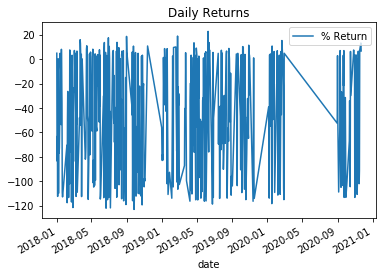

In [95]:
bets_df.plot(y='return',label='% Return')
plt.title("Daily Returns")